In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import timeseries
from bilby.gw.conversion import total_mass_and_mass_ratio_to_component_masses
from pesummary.gw.conversions.spins import opening_angle, component_spins
from pesummary.gw.conversions.angles import _dpsi, _dphi
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# My implementation

In [2]:
def gen_prec_wf(f_low, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, approximant='IMRPhenomXP', sample_rate=4096, apply_detector_response=True, work_in_fd=False, gen_in_fd=False):

    # Convert parameters
    mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, f_low, 0) # Do not think phi_jl or phase impact result
    dpsi = _dpsi(theta_jn, phi_jl, beta)
    dphi = _dphi(theta_jn, phi_jl, beta)
    if not gen_in_fd and not work_in_fd and apply_detector_response:
        phase += dphi
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = component_spins(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2, mass_1, mass_2, f_low, phase)

    if gen_in_fd:
        # # Generate freq domain waveform
        hp, hc = get_fd_waveform(approximant=approximant, 
                                 mass1=mass_1,
                                 mass2=mass_2,
                                 f_lower=f_low,
                                 delta_f=1/256,
                                 f_final=sample_rate/2,
                                 inclination=iota,
                                 spin1x=spin_1x,
                                 spin1y=spin_1y,
                                 spin1z=spin_1z,
                                 spin2x=spin_2x,
                                 spin2y=spin_2y,
                                 spin2z=spin_2z,
                                 coa_phase=phase)
    else:
        # Generate time domain waveform
        hp, hc = get_td_waveform(approximant=approximant, 
                                 mass1=mass_1,
                                 mass2=mass_2,
                                 f_lower=f_low,
                                 delta_t=1/sample_rate,
                                 inclination=iota,
                                 spin1x=spin_1x,
                                 spin1y=spin_1y,
                                 spin1z=spin_1z,
                                 spin2x=spin_2x,
                                 spin2y=spin_2y,
                                 spin2z=spin_2z,
                                 coa_phase=phase)

    if work_in_fd or gen_in_fd:
        hptilde = hp.to_frequencyseries()
        hctilde = hc.to_frequencyseries()
        fp = np.cos(2 * (psi - dpsi))
        fc = -1. * np.sin(2 * (psi - dpsi))
        h = (fp * hptilde + fc * hctilde)
        h *= np.exp(2j * dphi)
        h0 = h.to_timeseries(delta_t=1/sample_rate)
        h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
        ih = 1j*h
        hpi2 = ih.to_timeseries(delta_t=1/sample_rate)
        hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
        h = h0+1j*hpi2
    else:
    
        # 
        if apply_detector_response:
            fp = np.cos(2 * (psi - dpsi))
            fc = -1. * np.sin(2 * (psi - dpsi))
            h = (fp * hp + fc * hc)
        else:
            h = hp - 1j*hc
    
    return h

In [3]:
# Make precessing harmonics
def gen_prec_harms(f_low, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, harmonics=[0,1,2,3,4], approximant='IMRPhenomXP', sample_rate=4096, work_in_fd=True):

    # Generate constituent waveforms
    if 0 in harmonics or 4 in harmonics:
        x_0_0_0_0 = gen_prec_wf(f_low, M, q, 0, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
        x_0_0_pi4_pi4 = gen_prec_wf(f_low, M, q, 0, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
    if 1 in harmonics or 3 in harmonics:
        x_pi2_0_pi4_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, 0, np.pi/4, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
        x_pi2_pi2_0_pi4 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, np.pi/4, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
    if 2 in harmonics:
        x_pi2_0_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, 0, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)
        x_pi2_pi2_0_0 = gen_prec_wf(f_low, M, q, np.pi/2, np.pi/2, 0, 0, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=sample_rate, work_in_fd=work_in_fd)

    # Above uses six waveforms - can this be simplified to five?

    # Combine to make _0 harmonics
    harms = []
    if 0 in harmonics:
        harms.append((1/2)*(x_0_0_0_0-x_0_0_pi4_pi4))
    if 1 in harmonics:
        harms.append(-(1/4)*(x_pi2_0_pi4_pi4+x_pi2_pi2_0_pi4))
    if 2 in harmonics:
        harms.append((1/6)*(x_pi2_0_0_0+x_pi2_pi2_0_0))
    if 3 in harmonics:
        harms.append(-(1/4)*(x_pi2_0_pi4_pi4-x_pi2_pi2_0_pi4))
    if 4 in harmonics:
        harms.append((1/2)*(x_0_0_0_0+x_0_0_pi4_pi4))

    return harms

In [4]:
# Parameters
M = 60
q = 2
tilt_1 = np.pi/2
tilt_2 = np.pi/2
phi_12 = np.pi/2
a_1 = 0.7
a_2 = 0
approximant = 'IMRPhenomXP'
theta_jn = 0.76345435
phi_jl = 1.23536234
phase = 2.823454
psi = 3.8345

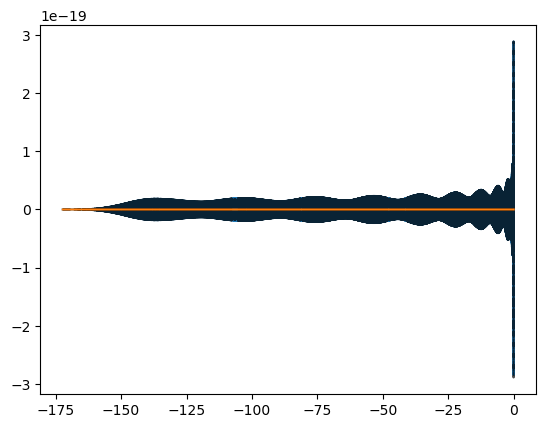

In [7]:
# Plot example waveform
h = gen_prec_wf(5, M, q, theta_jn, phi_jl, phase, psi, tilt_1, tilt_2, phi_12, a_1, a_2, gen_in_fd=False)

plt.plot(h.sample_times, h)
plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.imag().sample_times, h.imag())
# plt.xlim(h.sample_times[-1]-3, h.sample_times[-1]-2)

In [37]:
print(1/4096)

0.000244140625


In [46]:
print(h.sample_times[-1])

3.384033203125


In [1]:
%env

{'PATH': '/opt/conda/igwn-py310-20241016/epics/bin/linux-x86_64:/opt/conda/igwn-py310-20241016/epics/bin/linux-x86_64:/opt/conda3/bin:/opt/conda3/condabin:/opt/conda3/bin:/sbin:/bin:/usr/sbin:/usr/bin:/opt/dcs/sbin:/opt/dcs/bin',
 'CONDA_ROOT': '/opt/conda3',
 'CONDA_DEFAULT_ENV': 'base',
 'LANG': 'en_US.UTF-8',
 'JUPYTERHUB_API_TOKEN': '<hidden>',
 'JPY_API_TOKEN': '<hidden>',
 'JUPYTERHUB_CLIENT_ID': 'jupyterhub-user-ben.patterson',
 'JUPYTERHUB_COOKIE_HOST_PREFIX_ENABLED': '0',
 'JUPYTERHUB_HOST': '',
 'JUPYTERHUB_OAUTH_CALLBACK_URL': '/user/ben.patterson/oauth_callback',
 'JUPYTERHUB_OAUTH_SCOPES': '["access:servers!server=ben.patterson/", "access:servers!user=ben.patterson"]',
 'JUPYTERHUB_OAUTH_ACCESS_SCOPES': '["access:servers!server=ben.patterson/", "access:servers!user=ben.patterson"]',
 'JUPYTERHUB_OAUTH_CLIENT_ALLOWED_SCOPES': '[]',
 'JUPYTERHUB_USER': 'ben.patterson',
 'JUPYTERHUB_SERVER_NAME': '',
 'JUPYTERHUB_API_URL': 'http://127.0.0.1:8081/hub/api',
 'JUPYTERHUB_ACTIVIT

In [ ]:
# Plot example waveform
for _phase in [0, np.pi/4, 2*np.pi/4, 3*np.pi/4, 4*np.pi/4]:
    h = gen_prec_wf(20, M, q, theta_jn, phi_jl, _phase, psi, tilt_1, tilt_2, np.pi/2, 0.5, 0, work_in_fd=False, approximant='NRSur7dq2')
    print(h.sample_times[0])
    plt.plot(h.sample_times-h.sample_times[0], h)

# plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
# plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
# plt.plot(h.imag().sample_times, h.imag())
plt.xlim(2.5,3)

In [5]:
import h5py

In [6]:
path = '/home/ben.patterson/.conda/envs/igwn_eccentric/src/lalsuite-extra/data/lalsimulation/NRSur7dq4.h5'
with h5py.File(path, 'r') as f:
   for key in f.keys():
       print(key)

OSError: Unable to synchronously open file (file signature not found)

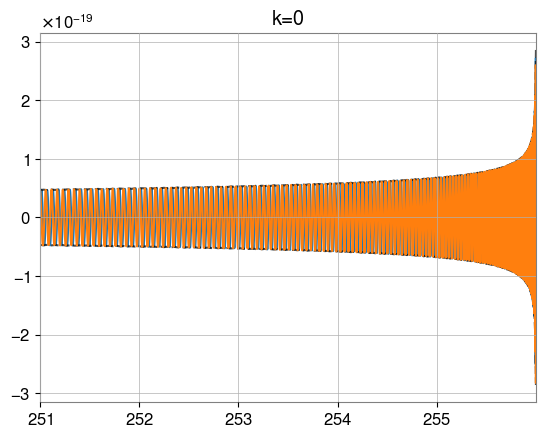

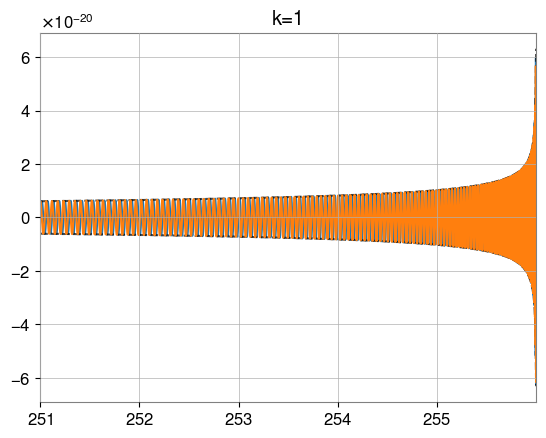

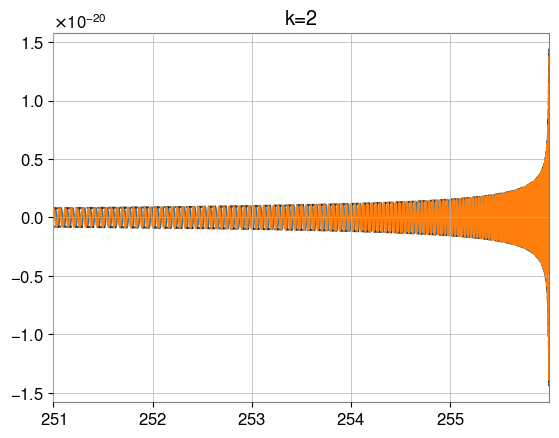

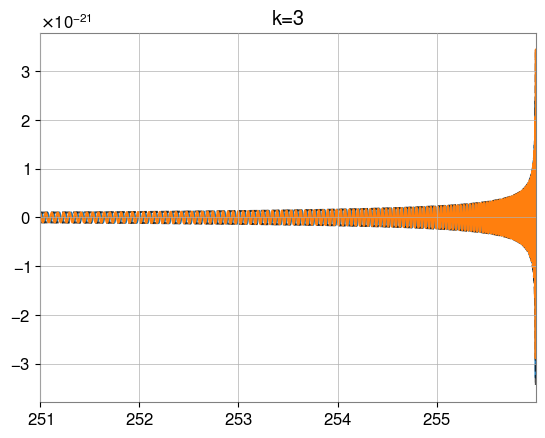

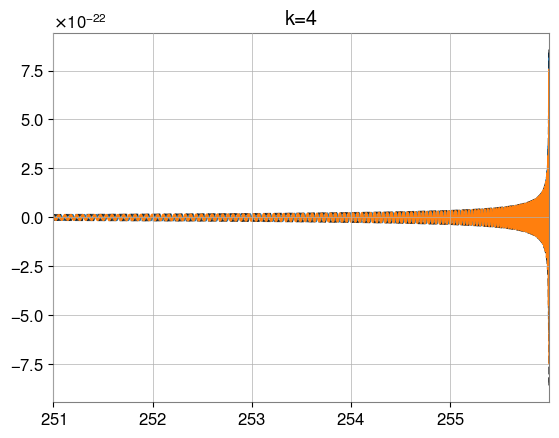

In [32]:
# Plot harmonics
harms = gen_prec_harms(5, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant)

for i in range(len(harms)):
    plt.plot(harms[i].sample_times, harms[i])
    plt.plot(harms[i].sample_times, np.abs(harms[i]), ls='dashed', c='k', alpha=0.7)
    plt.plot(harms[i].sample_times, -np.abs(harms[i]), ls='dashed', c='k', alpha=0.7)
    plt.plot(harms[i].imag().sample_times, harms[i].imag())
    plt.title(f'k={i}')
    plt.xlim(harms[i].sample_times[-1]-5, harms[i].sample_times[-1]-0)
    plt.show()

# Pesummary implementation

In [7]:
from pesummary.gw.conversions.snr import _calculate_precessing_harmonics, _make_waveform

In [8]:
# Parameters
M = 30
q = 2
tilt_1 = np.pi/2
tilt_2 = np.pi/2
phi_12 = np.pi/2
a_1 = 0.7
a_2 = 0
approximant = 'IMRPhenomXP'
theta_jn = 0.76345435
phi_jl = 1.23536234
phase = 2.823454
psi = 3.8345

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(252.99951171875, 253.99951171875)

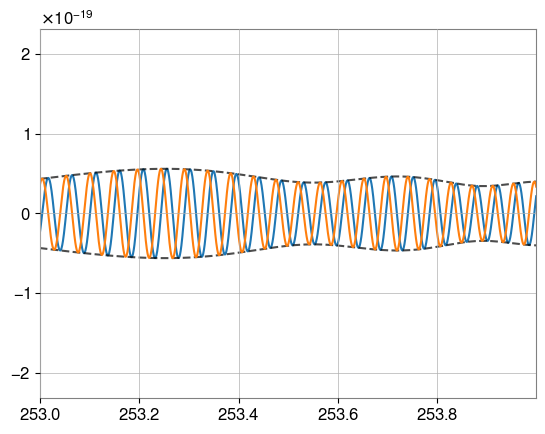

In [9]:
# Example waveform
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
h = _make_waveform(approximant, theta_jn, phi_jl, phase, psi, mass_1, mass_2, tilt_1, tilt_2, phi_12, a_1, a_2, beta, 1)
h0 = h.to_timeseries()
h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
ih = 1j*h
hpi2 = ih.to_timeseries()
hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
h = h0+1j*hpi2

plt.plot(h.sample_times, h)
plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
plt.plot(h.imag().sample_times, h.imag())
plt.xlim(h.sample_times[-1]-3,h.sample_times[-1]-2)

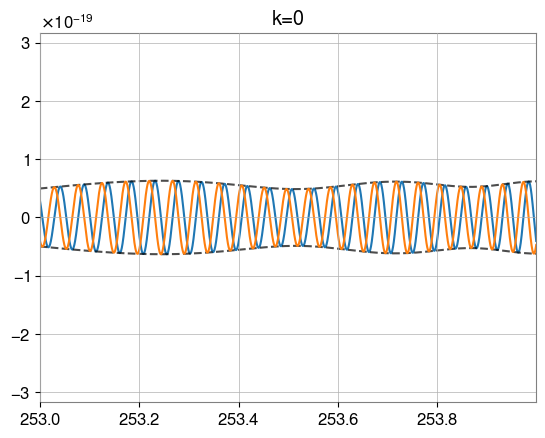

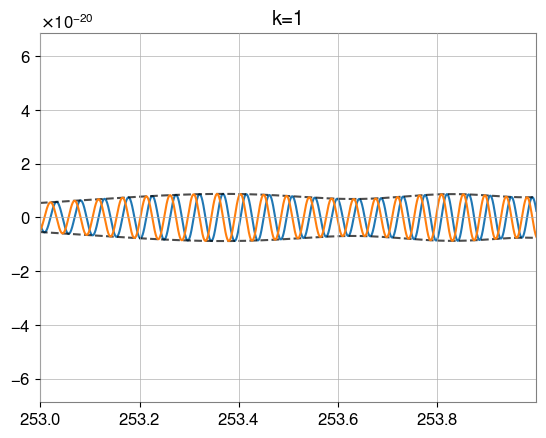

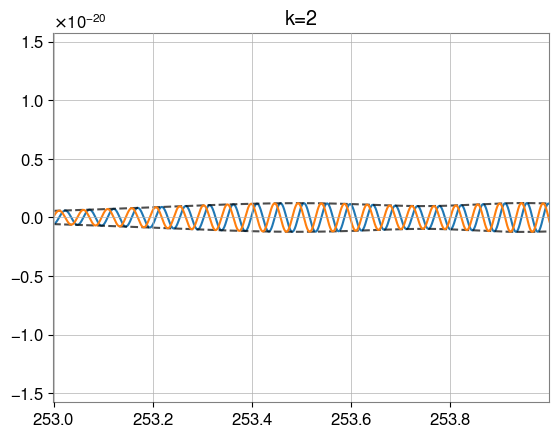

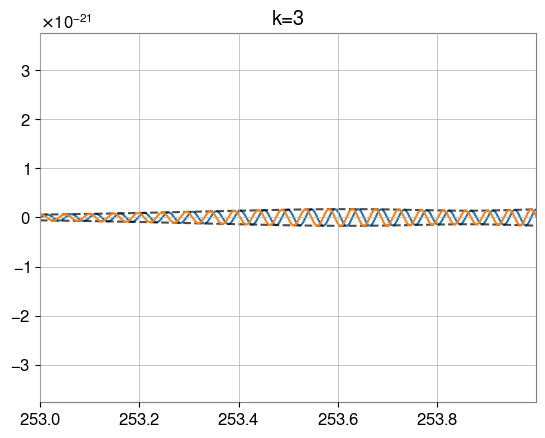

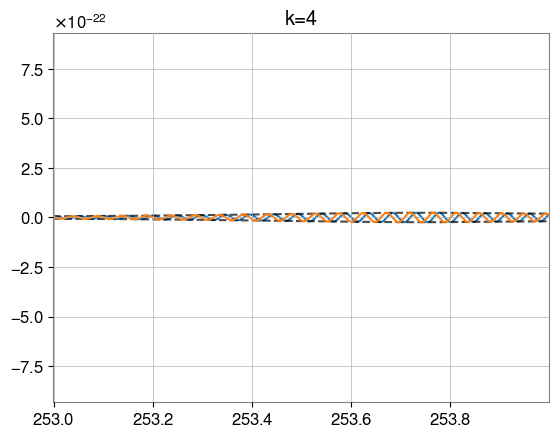

In [10]:
# Plot harmonics
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
harms = _calculate_precessing_harmonics(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, beta, 1, harmonics=[0,1,2,3,4], approx=approximant)

for i in range(len(harms)):
    h0 = harms[i].to_timeseries()
    h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
    ih = 1j*harms[i]
    hpi2 = ih.to_timeseries()
    hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
    h = h0+1j*hpi2
    plt.plot(h.sample_times, h)
    plt.plot(h.sample_times, np.abs(h), ls='dashed', c='k', alpha=0.7)
    plt.plot(h.sample_times, -np.abs(h), ls='dashed', c='k', alpha=0.7)
    plt.plot(h.imag().sample_times, h.imag())
    plt.title(f'k={i}')
    plt.xlim(h.sample_times[-1]-3,h.sample_times[-1]-2)
    plt.show()

# Comparing results

In [37]:
# Parameters
M = 30
q = 2
tilt_1 = np.pi/4
tilt_2 = np.pi/3
phi_12 = np.pi/2.3
a_1 = 0.7
a_2 = 0.5
approximant = 'IMRPhenomXP'

## Match of each harmonic

In [ ]:
# Harmonics from our functions
our_harms = gen_prec_harms(20, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant, sample_rate=2048)

# Harmonics from pesummary
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
pe_harms = _calculate_precessing_harmonics(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, beta, 1, harmonics=[0,1,2,3,4], approx=approximant)

# Compute match
psd = aLIGOZeroDetHighPower(len(pe_harms[0]), pe_harms[0].delta_f, 20)
for i in range(len(our_harms)):

    # Transform pesummary harmonic to time domain
    h0 = pe_harms[i].to_timeseries()
    h0 = timeseries.TimeSeries(h0, delta_t=h0.delta_t, epoch=0, dtype=np.complex128)
    ih = 1j*pe_harms[i]
    hpi2 = ih.to_timeseries()
    hpi2 = timeseries.TimeSeries(hpi2, delta_t=hpi2.delta_t, epoch=0, dtype=np.complex128)
    pe_harm = h0+1j*hpi2
    our_harm, pe_harm = resize_wfs([our_harms[i], pe_harm])
    psd = gen_psd(our_harm, 20)

    # Print match
    print(i, match(our_harm.real(), pe_harm.real(), psd=psd, low_frequency_cutoff=20)[0])

0 0.9997876960303207
1 0.9653974683179928


## Check orthogonality

In [34]:
# Get harmonics
harms = gen_prec_harms(20, M, q, tilt_1, tilt_2, phi_12, a_1, a_2, approximant=approximant)

# Compute orthogonality
for i in range(len(harms)):
    for j in range(i+1):
        print(i, j, np.abs(overlap_cplx_wfs(harms[i], harms[j], 20, f_match=20, normalized=True)))
    print('\n')

0 0 1.0


1 0 0.05725389894233293
1 1 1.0


2 0 0.054841090294264004
2 1 0.09070325469072243
2 2 0.9999999999999998


3 0 0.046313000919417
3 1 0.07370027186827287
3 2 0.13551446246370308
3 3 1.0


4 0 0.04290425422997173
4 1 0.06504962005229685
4 2 0.10236612286284286
4 3 0.19490330403986364
4 4 0.9999999999999999




In [35]:
# Get harmonics
mass_1, mass_2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
beta = opening_angle(mass_1, mass_2, 0, tilt_1, tilt_2, phi_12, a_1, a_2, 20, 0)
harms = _calculate_precessing_harmonics(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, beta, 1, harmonics=[0,1,2,3,4], approx=approximant)
psd = aLIGOZeroDetHighPower(len(harms[0]), harms[0].delta_f, 20)

# Check orthogonality
for i in range(len(harms)):
    for j in range(i+1):
        print(i, j, np.abs(overlap_cplx(harms[i], harms[j], psd=psd, low_frequency_cutoff=20)))
    print('\n')

0 0 1.0


1 0 0.0571311216188576
1 1 1.0


2 0 0.05551949144119885
2 1 0.09051091723001596
2 2 0.9999999999999998


3 0 0.046611443919037626
3 1 0.07422390393078732
3 2 0.13502421077147356
3 3 0.9999999999999999


4 0 0.03898836595773121
4 1 0.06046892000503533
4 2 0.09658590766139541
4 3 0.18822269760773988
4 4 1.0


